In [1]:
# libraries for data exploration.
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
import seaborn as sns

# library for splitting data.
from sklearn.model_selection import train_test_split

# libraries for preparing the data.
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# libraries for building linear models.
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# library for measuring error. 
from sklearn.metrics import mean_squared_error

# time series specific libararies
from scipy.signal import periodogram
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# user defined.
from helpful_functions import MLFunctions
from plot_setup import *

In [2]:
# load sales data.
sales = pd.read_csv("../../../Data/future_sales/sales_train.csv",
                    usecols=['date', 'item_cnt_day'],
                    index_col='date',
                    parse_dates=['date'])

In [3]:
sales = sales.groupby('date').mean()

In [4]:
sales.index = pd.to_datetime(sales.index, format="%d.%m.%Y")
sales.index = sales.index.to_period('D')
sales = sales.sort_index()

In [9]:
helper_function = MLFunctions(sales)
arr = helper_function.dateNum()

In [11]:
sales['time'] = arr

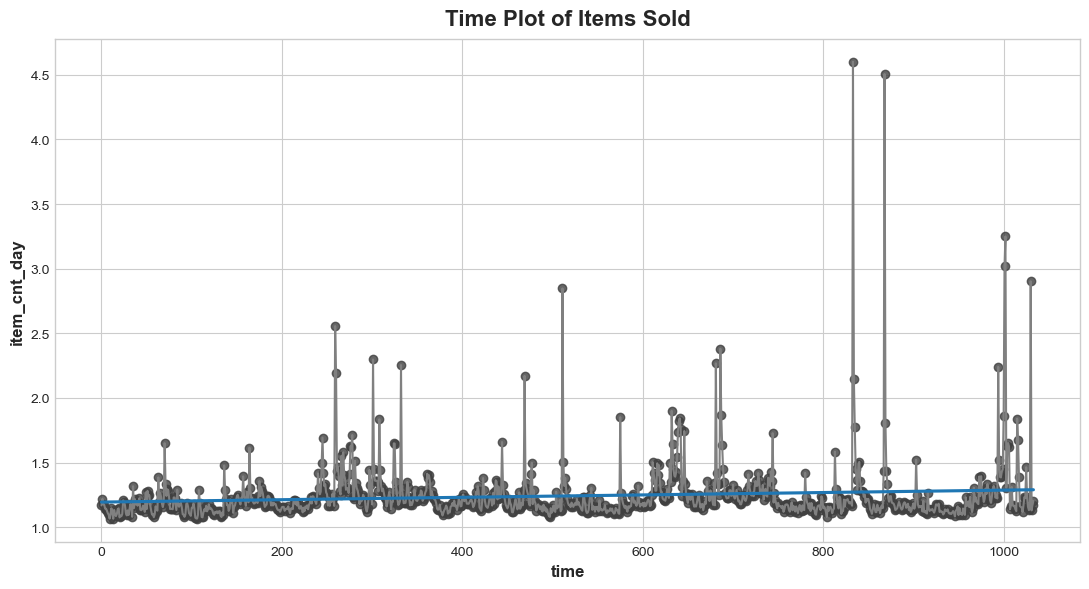

In [13]:
fig, ax = plt.subplots()
ax.plot('time', 'item_cnt_day', data=sales, color='0.5')
ax = sns.regplot(x='time', y='item_cnt_day', data=sales, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Items Sold');

In [15]:
sales['lag_1'] = sales['item_cnt_day'].shift(1)

In [17]:
sales.head()

,item_cnt_day,time,lag_1
date,,,
2013-01-01,1.168963,0,NaN
2013-01-02,1.220304,1,1.168963
2013-01-03,1.178469,2,1.220304
2013-01-04,1.174476,3,1.178469
2013-01-05,1.144454,4,1.174476


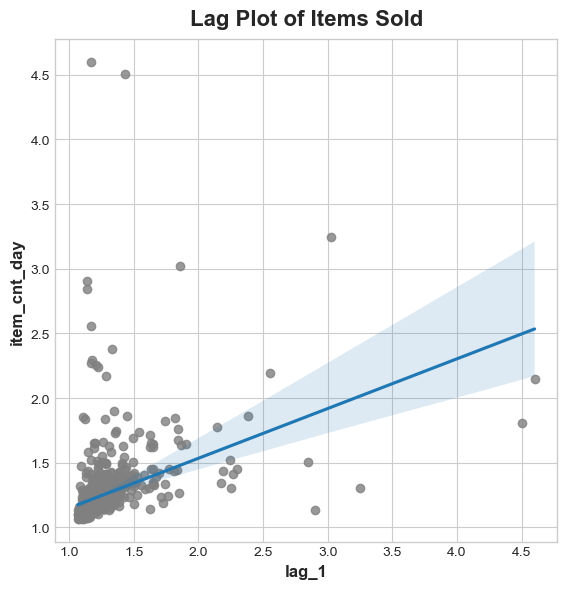

In [19]:
fig, ax = plt.subplots()
ax = sns.regplot(x='lag_1', y='item_cnt_day', data=sales, ci=95, scatter_kws=dict(color='0.5'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Items Sold');

In [21]:
sales.head()

,item_cnt_day,time,lag_1
date,,,
2013-01-01,1.168963,0,NaN
2013-01-02,1.220304,1,1.168963
2013-01-03,1.178469,2,1.220304
2013-01-04,1.174476,3,1.178469
2013-01-05,1.144454,4,1.174476


In [23]:
items_sold = sales.loc[:, ['item_cnt_day']]
trend = items_sold.rolling(window=120,
                           center=True,
                           min_periods=60).mean()

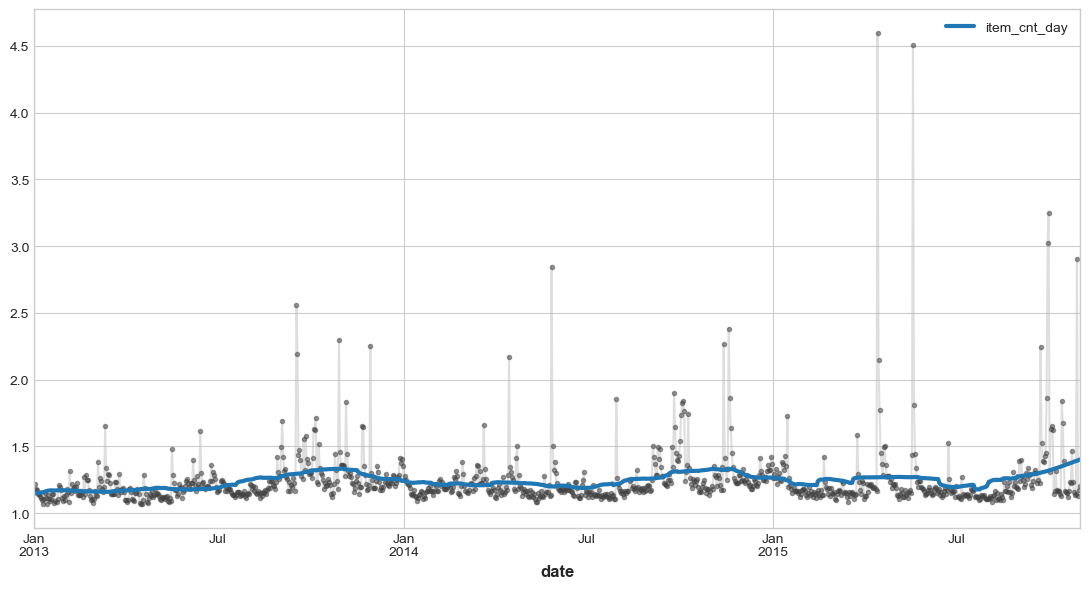

In [25]:
# Make a plot
ax = items_sold.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

In [45]:
# below code shows how fourier features are generated
'''
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)
fourier = fourier_features(sales.index, freq=365.25, order=4)
'''

'\ndef fourier_features(index, freq, order):\n    time = np.arange(len(index), dtype=np.float32)\n    k = 2 * np.pi * (1 / freq) * time\n    features = {}\n    for i in range(1, order + 1):\n        features.update({\n            f"sin_{freq}_{i}": np.sin(i * k),\n            f"cos_{freq}_{i}": np.cos(i * k),\n        })\n    return pd.DataFrame(features, index=index)\nfourier = fourier_features(sales.index, freq=365.25, order=4)\n'

In [39]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [41]:
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax